In [1]:
from PIL import Image
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import math
import random
import argparse
import logging
import json
import cv2
import datetime
import shapely.wkt
import shapely
from shapely.geometry import Polygon
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import shapely.wkt
import tensorflow as tf
import tensorflow.keras
import ast
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Add, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import backend as K
from sklearn.utils import compute_class_weight
from tensorflow.keras.layers import Dropout, Conv2D, MaxPooling2D, Dense, Flatten, Add, Input, Concatenate,LayerNormalization, BatchNormalization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import f1_score

2023-08-01 03:38:34.037715: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-01 03:38:34.195154: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-01 03:38:34.233480: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-01 03:38:35.151620: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [6]:
# create some needed folders
folders = ['output','model']
for folder in folders:
    if (os.path.isdir(folder)):
        continue
    else:
        os.makedirs(folder)

### Agenda

1. Labels
2. Data processing
3. Modelling
4. Validation
5. Analysis

### 1. Labels

In [2]:
from IPython.display import Image
Image(url="levels.png", width=900, height=900)

### 2. Data processing

The goal of the data processing is to:
(1) clip satellite images with building footprint polygons
(2) create CSVs that maps the these clipped images to their labels

In [2]:
# we need to encode the labels in the dictionary to be used later
damage_intensity_encoding = defaultdict(lambda: 0)
damage_intensity_encoding['destroyed'] = 3
damage_intensity_encoding['major-damage'] = 2
damage_intensity_encoding['minor-damage'] = 1
damage_intensity_encoding['no-damage'] = 0

In [3]:
def process_img(img_array, polygon_pts, scale_pct):
    """Process Raw Data into
            Args:
                img_array (numpy array): numpy representation of image.
                polygon_pts (array): corners of the building polygon.
            Returns:
                numpy array: .
    """

    height, width, _ = img_array.shape

    xcoords = polygon_pts[:, 0]
    ycoords = polygon_pts[:, 1]
    xmin, xmax = np.min(xcoords), np.max(xcoords)
    ymin, ymax = np.min(ycoords), np.max(ycoords)

    xdiff = xmax - xmin
    ydiff = ymax - ymin

    #Extend image by scale percentage
    xmin = max(int(xmin - (xdiff * scale_pct)), 0)
    xmax = min(int(xmax + (xdiff * scale_pct)), width)
    ymin = max(int(ymin - (ydiff * scale_pct)), 0)
    ymax = min(int(ymax + (ydiff * scale_pct)), height)

    return img_array[ymin:ymax, xmin:xmax, :]

In [4]:
def process_data(images, buildings, train_csv, test_csv, val_split_pct, event_type):

    from PIL import Image
    
    x_data = []
    y_data = []
    
   
    if not event_type:
        image_paths = [images + "/" + pic for pic in os.listdir(images)]
    else:
        image_paths = [images + "/" + pic for pic in os.listdir(images) if event_type.lower() in pic]
        
    for img_path in tqdm(image_paths):
        img_obj = Image.open(img_path)
        img_array = np.array(img_obj)

        #Get corresponding label for the current image
        label_path = img_path.replace('png', 'json').replace('images', 'labels')
        if os.path.exists(label_path):
            label_file = open(label_path)
            label_data = json.load(label_file)

        for feat in label_data['features']['xy']:

            # only images post-disaster will have damage type
            try:
                damage_type = feat['properties']['subtype']
            except: # pre-disaster damage is default no-damage
                damage_type = "no-damage"
                continue

            poly_uuid = feat['properties']['uid'] + ".png"

            y_data.append(damage_intensity_encoding[damage_type])

            if not (os.path.exists(buildings + "/" + poly_uuid)):
                try:
                    polygon_geom = shapely.wkt.loads(feat['wkt'])
                    polygon_pts = np.array(list(polygon_geom.exterior.coords))
                    poly_img = process_img(img_array, polygon_pts, 0.8)
                    cv2.imwrite(buildings + "/" + poly_uuid, poly_img)
                except Exception as e:
                    print(label_path)
                    print(poly_uuid)
                    print(e)
            x_data.append(poly_uuid)
            
    # save train and test csv
    if(val_split_pct > 0):
        x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=val_split_pct)
        data_array_train = {'uuid': x_train, 'labels': y_train}
        data_array_test = {'uuid': x_test, 'labels': y_test}
        df_train = pd.DataFrame(data_array_train)
        df_test = pd.DataFrame(data_array_test)
        df_train.to_csv(train_csv)
        df_test.to_csv(test_csv)
    else:
        data_array = {'uuid': x_data, 'labels': y_data}
        df = pd.DataFrame(data = data_array)
        df.to_csv(output_train_csv_path)

In [5]:
images = r'../train/images/' # path to images
buildings = './output/buildings' # path to store clipped images
train_csv = './output/csv/train.csv' # csv that maps clipped images to labels for train data
test_csv = './output/csv/test.csv' # csv that maps clipped images to labels for test data

In [26]:
# To visualize the content of JSON file
with open(r'../train/labels/midwest-flooding_00000108_post_disaster.json') as f:
                data = json.load(f)
                json_formatted_str = json.dumps(data, indent=2)
                print(json_formatted_str)

{
  "features": {
    "lng_lat": [
      {
        "properties": {
          "feature_type": "building",
          "subtype": "no-damage",
          "uid": "e00bc2ea-b2af-4093-8685-048d0066b480"
        },
        "wkt": "POLYGON ((-96.212499955154 36.3519482129479, -96.21253022976323 36.35203504853087, -96.21252561738027 36.3521197841531, -96.21227522376184 36.3521447904353, -96.212254508971 36.35196819268099, -96.212499955154 36.3519482129479))"
      },
      {
        "properties": {
          "feature_type": "building",
          "subtype": "no-damage",
          "uid": "cf7faa40-6311-4fc6-81fb-b77b7d863321"
        },
        "wkt": "POLYGON ((-96.21213594970499 36.35189727306844, -96.21214327404294 36.35193155440162, -96.21214327880593 36.351963360081, -96.21196421864767 36.35196701528607, -96.2119502369187 36.35194364129761, -96.21195345707359 36.35190130906677, -96.21213594970499 36.35189727306844))"
      },
      {
        "properties": {
          "feature_type": "building"

In [6]:
# you only have to run this once to create the csv files
event_type = 'flooding' # e.g. 'flooding', 'hurricane', None is for all.
val_split_pct = 0.1 # 10% of data would be used for testing
process_data(images, buildings, train_csv, test_csv, val_split_pct, event_type)

100%|██████████| 558/558 [00:17<00:00, 31.67it/s]


In [7]:
df = pd.read_csv('./output/csv/train.csv', index_col=0)
df.head()

,uuid,labels
0,72c73ff9-e8e9-4d66-b6e2-7dfb59dc3fdd.png,0
1,043367e0-bcac-47ae-ac18-2437ef27b2b0.png,0
2,fd1bca7d-4317-4c70-81de-6c6059750b61.png,0
3,8190130a-0370-4051-a38c-6aeae8c192b5.png,0
4,058f666f-b245-425e-b628-5dcf2b32a5aa.png,0


In [11]:
# The dataset is highly imbalance, with no-damage over-representated
df.groupby('labels').count()

,uuid
labels,
0,7572
1,138
2,108
3,62


### 3. Modelling

<table>
<row>
<td>
<center>
<img src="baselineAlgorithm.png" width="900"/>
<center>
</td>
</row>
</table>
<table>
<row>
<td>.
    <center>
<img src="baselineF1score.png" width="500"/>
        <center>
</td>
</row>
</table>

In [12]:
def generate_xBD_baseline_model():
    
        weights = 'imagenet'
        inputs = Input(shape=(128, 128, 3))

        base_model = ResNet50(include_top=False, weights=weights, input_shape=(128, 128, 3))

        for layer in base_model.layers:
            layer.trainable = False
        
        #layer = LayerNormalization()
        #x = layer(inputs)
        x = Conv2D(32, (5, 5), strides=(1, 1), padding='same', activation='relu', input_shape=(128, 128, 3))(inputs)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)
        x = Conv2D(64, (5, 5), strides=(1, 1), padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)
        x = Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)
        x = Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)
        x = Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)
        x = Flatten()(x)

        base_resnet = base_model(inputs)
        base_resnet = Flatten()(base_resnet)

        concated_layers = Concatenate()([x, base_resnet])

        concated_layers = Dense(512, activation='relu',kernel_regularizer='l1')(concated_layers)
        concated_layers = Dropout(0.2)(concated_layers)
        concated_layers = Dense(256, activation='relu',kernel_regularizer='l1')(concated_layers)
        concated_layers = Dense(128, activation='relu')(concated_layers)
        output = Dense(4, activation='relu')(concated_layers)

        model = Model(inputs=inputs, outputs=output)
        return model

In [13]:
damage_intensity_encoding_for_model = dict()
damage_intensity_encoding_for_model[3] = '3' # destroyed
damage_intensity_encoding_for_model[2] = '2' # major-damage
damage_intensity_encoding_for_model[1] = '1' # minor-damage
damage_intensity_encoding_for_model[0] = '0' # no-damage

In [14]:
def f1(y_true, y_pred):
    
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)


In [16]:
# run training and evaluation based on existing or new model
def train_model(train_data, train_csv, test_data, test_csv, epochs):
    
    df = pd.read_csv(train_csv)
    
    class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(df['labels'].values.tolist()),
                                        y =  df['labels'].values.tolist())  
    d_class_weights = dict(enumerate(class_weights))
    
    print(f'weights: {d_class_weights}')

    model = generate_xBD_baseline_model()
    
    model.summary()

    step = tf.Variable(0, trainable=False)
    boundaries = [5]
    values = [0.0001,0.00001]
    learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
    learning_rate = learning_rate_fn(step)                                           

   
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=f1_loss,
        metrics=[f1]
    )

    train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=False,
                             width_shift_range=0.05,                               
                             height_shift_range=0.05,
                             zoom_range=0.01,
                             rotation_range=2,
                             rescale=1./255.,
                             validation_split=0.1)
  

    train_generator=train_datagen.flow_from_dataframe(
                                                dataframe=df.replace({"labels" : damage_intensity_encoding_for_model }),
                                                directory=train_data,
                                                x_col="uuid",
                                                y_col="labels",
                                                subset="training",
                                                batch_size=32,
                                                seed=42,
                                                shuffle=False,
                                                class_mode="categorical",
                                                target_size=(128,128))


    STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
    
    #Filepath to save model weights
    model_out = './output/save/'
    filepath = model_out + "-saved-model-{epoch:02d}-{loss:.2f}.hdf5"
    checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath,
                                                    monitor='loss',
                                                    verbose=1,
                                                    save_best_only=True,
                                                    mode='min')

    #Training begins
    model.fit(train_generator,
                        steps_per_epoch=STEP_SIZE_TRAIN,
                        epochs=epochs,
                        workers=4,
                        use_multiprocessing=True,
                        class_weight=d_class_weights,
                        callbacks=[checkpoints],
                        verbose=1)
    
    return model

In [ ]:
# train the algorithm and generate the model
model = train_model(train_data=buildings, train_csv=train_csv, test_data=buildings, test_csv=test_csv,epochs=100)

weights {0: 0.2601690438457475, 1: 14.27536231884058, 2: 18.24074074074074, 3: 31.774193548387096}
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 128, 128, 32  2432        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_10 (BatchN  (None, 128, 128, 32  128        ['conv2d_10[0][0]']        

### 4. Validation

In [19]:
# model's metric
model.history.history.keys()

dict_keys(['loss', 'f1'])

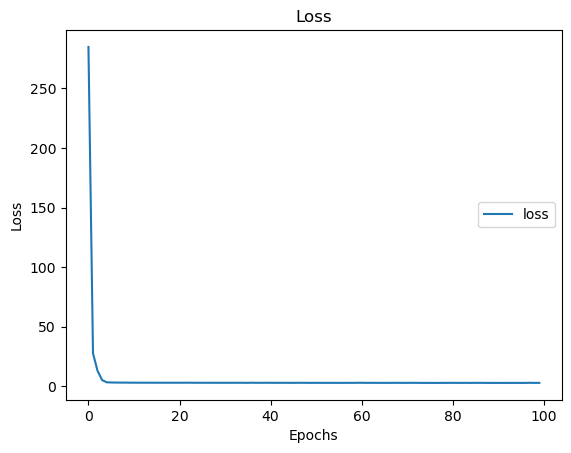

In [20]:
# plot loss curve
plt.title('Loss')
plt.plot(model.history.history['loss'], label='loss')
plt.legend(loc='center right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='center right');

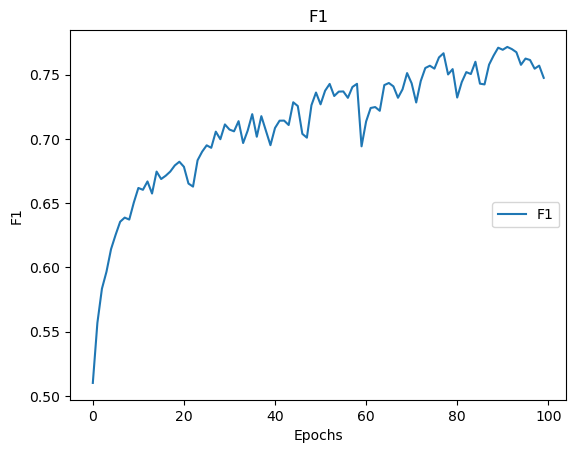

In [21]:
# plot F1 curve
plt.title('F1')
plt.plot(model.history.history['f1'], label='F1')
plt.legend(loc='center right')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.legend(loc='center right');

In [22]:
# save the model
model.save('model/classification_model')

INFO:tensorflow:Assets written to: model/classification_model/assets


INFO:tensorflow:Assets written to: model/classification_model/assets


In [12]:
# Load model only if a model was saved.
#model = tf.keras.models.load_model('model/classification_model', custom_objects={'f1': f1,'f1_loss':f1_loss}, 
                                               #compile=True)

In [23]:
# test model
test_df = pd.read_csv(test_csv)
test_datagen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
                                                dataframe=test_df.replace({"labels" : damage_intensity_encoding_for_model }),
                                                directory=buildings,
                                                x_col="uuid",
                                                y_col="labels",
                                                batch_size=32,
                                                seed=42,
                                                shuffle=False,
                                                class_mode="categorical",
                                                target_size=(128,128))

Found 876 validated image filenames belonging to 4 classes.


In [24]:
predictions = model.predict(test_generator)

28/28 [==============================] - 3s 64ms/step


In [25]:
test_trues = test_generator.classes
test_pred = np.argmax(predictions, axis=-1)

f1_weighted = f1_score(test_trues, test_pred, average='weighted')
print(f1_weighted)

0.950294003618506


### 5. Analysis

In [26]:
result_df = pd.DataFrame({'test':test_trues, 'pred': test_pred, 'filepath':test_generator.filepaths})

In [27]:
result_df.head()

,test,pred,filepath
0,0,0,./output/buildings/7574e436-418e-4387-8b92-ea2...
1,0,0,./output/buildings/7ff864cb-bd53-41d2-b017-b32...
2,0,0,./output/buildings/011604e8-28a0-4a50-9340-f01...
3,0,0,./output/buildings/844cd97b-6c10-43e7-86d2-afd...
4,0,0,./output/buildings/a61688ca-6e30-4e98-8923-541...


#### No-damage

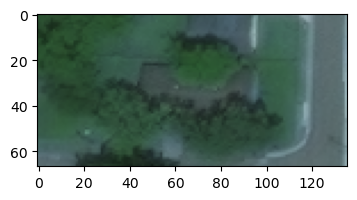

In [29]:
plt.figure(figsize= (4,4))
img = plt.imread(result_df['filepath'][2])
plt.imshow(img);

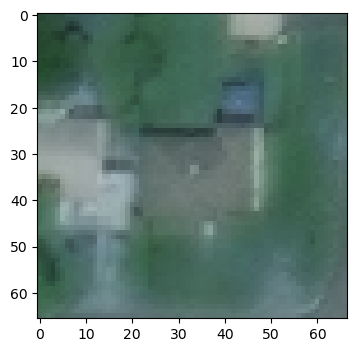

In [30]:
plt.figure(figsize= (4,4))
img = plt.imread(result_df['filepath'][3])
plt.imshow(img);

#### Minor damage

In [31]:
result_df[(result_df.test==result_df.pred)&(result_df.test==1)]

,test,pred,filepath
669,1,1,./output/buildings/b5c28723-5954-45f9-b39e-a54...
777,1,1,./output/buildings/7b176a6f-249f-4db5-983e-cc7...


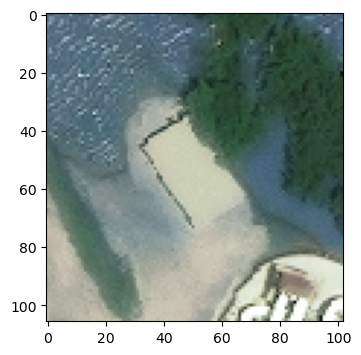

In [32]:
plt.figure(figsize= (4,4))
img = plt.imread(result_df['filepath'][669])
plt.imshow(img);

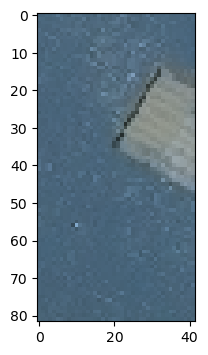

In [33]:
plt.figure(figsize= (4,4))
img = plt.imread(result_df['filepath'][777])
plt.imshow(img, interpolation='none');

#### Major damage

In [35]:
result_df[(result_df.test==result_df.pred)&(result_df.test==2)].head(20)

,test,pred,filepath


#### Destroyed

In [37]:
result_df[(result_df.test==result_df.pred)&(result_df.test==3)].head(20)

,test,pred,filepath


### Exercise

1. Let's see if we can improve the performance of the model by changing the model's parameters such as the learning rate,epochs and augmentation parameters. 
2. Also, let's analyze the result to see how well the model is able to classify the buildings by visualizing the results and comparing them to predicted and expected label.
3. We can train with the whole dataset or even try individual disaster types like hurricane, earthquake etc. to see how the models performs.